# ODE Pinn from scratch
The goals is to write my own PINN that finds the solution to an ODE

First import packages

In [31]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name(0))  # Name of your GPU

NVIDIA GeForce RTX 3070


# The ODE
$$\frac{d^{2}u}{dt^2}-3\frac{du}{dt}+2u=0$$

$$u(0)=4,\,\,\,\frac{du}{dt}(0)=5$$

Define exact solution

In [32]:
def exact_sol(t):
    u = 2*torch.cos(2*t)
    return u     

Define the neural network architecture, in this case the number of hidden layers is a parameter and they are all identical 

In [33]:
class FCN(nn.Module):
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.in_layer = nn.Sequential(*[
            nn.Linear(N_INPUT,N_HIDDEN),
            activation()])
        self.hid_layer = nn.Sequential(*[
            nn.Sequential(*[
                nn.Linear(N_HIDDEN,N_HIDDEN),
                activation()]) for _ in range(N_LAYERS - 1)])
        self.out_layer = nn.Linear(N_HIDDEN,N_OUTPUT)
    
    def forward(self, x):
        x = self.in_layer(x)
        x = self.hid_layer(x)
        x = self.out_layer(x)
        return x  

Generate Noisy Data

In [34]:
torch.manual_seed(123) # to ensure "random" values yield the same results everytime
t_obs = torch.rand(40).view(-1,1).to(device)
u_obs = exact_sol(t_obs) + 0.04*torch.randn_like(t_obs)

Train the PINN!

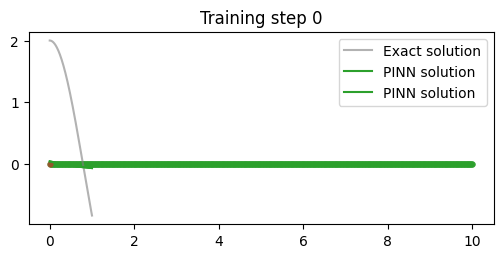

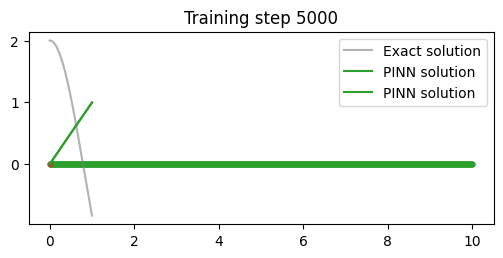

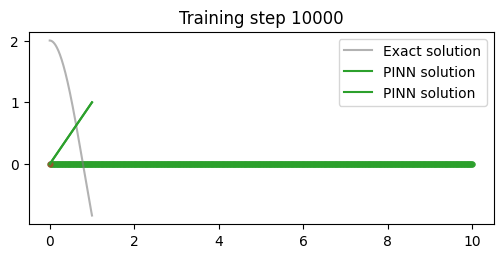

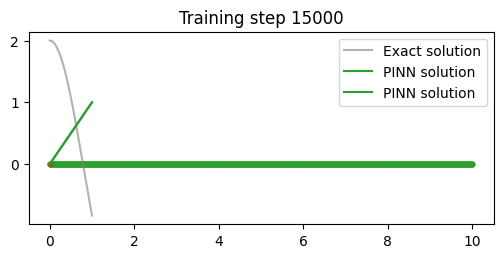

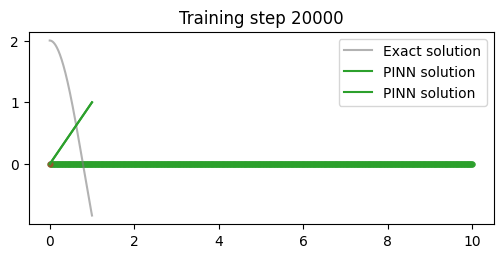

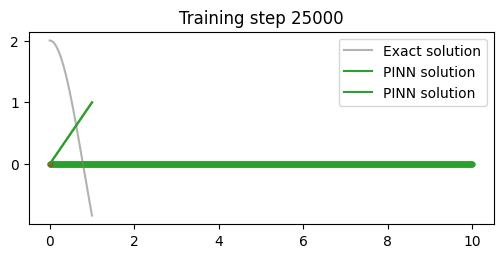

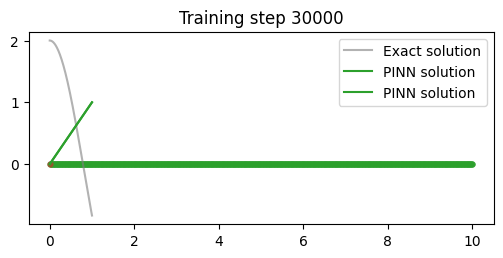

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

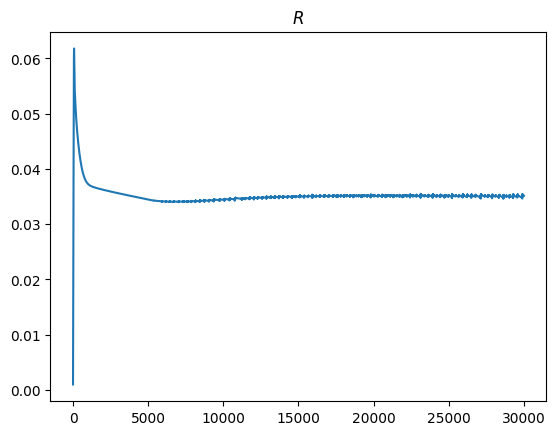

In [36]:
torch.manual_seed(123)

# Define NN
pinn = FCN(1,1,32,3).to(device)

# Define Boundary Points
t_boundary = torch.tensor(0.).view(-1,1).requires_grad_(True).to(device)

# Define Domain
t_physics = torch.linspace(0,10,1000).view(-1,1).requires_grad_(True).to(device)

# Make R a trainable parameter
coef = nn.Parameter(torch.zeros(1, requires_grad=True, device=device))
coefs= []

# Train the PINN
t_test = torch.linspace(0,1,300).view(-1,1).to(device)
u_exact = exact_sol(t_test)
optimiser = torch.optim.Adam(list(pinn.parameters())+[coef],lr=1e-3)
for i in range(30001):
    optimiser.zero_grad()
    
    lambda1 = 1e4

    # compute physics loss
    u = pinn(t_physics)
    dudt = torch.autograd.grad(u, t_physics, torch.ones_like(u), create_graph=True)[0]
    d2udt2 = torch.autograd.grad(dudt, t_physics, torch.ones_like(dudt), create_graph=True)[0]
    loss1 = torch.mean((d2udt2 + coef*u)**2)
    
    # compute data loss
    # TODO: write code here
    u = pinn(u_obs)
    loss2 = torch.mean((u - u_obs)**2)

    loss = loss1 + (lambda1 * loss2)
    loss.backward()
    optimiser.step()

    coefs.append(coef.item())


    if i % 5000 == 0: 
        #print(u.abs().mean().item(), dudt.abs().mean().item(), d2udt2.abs().mean().item())
        u = pinn(t_test).detach().cpu()
        plt.figure(figsize=(6,2.5))
        plt.scatter(t_physics.detach().cpu()[:, 0], 
            torch.zeros_like(t_physics).cpu()[:, 0], 
            s=20, lw=0, color="tab:green", alpha=0.6)
        plt.scatter(t_boundary.detach().cpu()[:, 0], 
                    torch.zeros_like(t_boundary).cpu()[:, 0], 
                    s=20, lw=0, color="tab:red", alpha=0.6)
        plt.plot(t_test.cpu()[:, 0], u_exact.cpu()[:, 0], label="Exact solution", color="tab:grey", alpha=0.6)
        plt.plot(t_test.cpu()[:, 0], u.cpu()[:, 0], label="PINN solution", color="tab:green")
        plt.plot(t_test.cpu()[:,0], u.cpu()[:,0], label="PINN solution", color="tab:green")
        plt.title(f"Training step {i}")
        plt.legend()
        plt.show()

plt.figure()
plt.title("$R$")
plt.plot(coefs, label="PINN estimate")
plt.hlines(coef.cpu(), 0, len(coefs), label="True value", color="tab:green")
plt.legend()
plt.xlabel("Training step")
plt.show()

In [20]:
print(torch.zeros(2,1))

tensor([[0.],
        [0.]])
